# Bragg Edge Fitting Step-by-Step

__Outline__

- Introduction
- The Santisteban model (Kropff model)
  - Physics-based attenuation model
  - Phenomenological peak shape function
  - Simulating the Bragg Edge
  - Fitting the Bragg Edge
  - Limitations
- The Extended Kropff model
  - Phenomenological attenuation model
  - Phenomenological peak shape function
  - Simulating the transmission spectrum with one Bragg edge
  - Fitting the Bragg Edge
  - Limitations
- `iBeatles` fits the Bragg Edge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import special
from lmfit import Model, Parameter

## Introduction

### Bragg Edge Imaging

Bragg edge imaging is a neutron imaging technique used to study the crystalline structure of materials.
It relies on the phenomenon where neutron transmission through a polycrystalline sample drops sharply at specific wavelengths, known as Bragg edges.
These edges correspond to the constructive interference condition for different crystallographic planes within the material.
This technique is particularly useful for characterizing strain, texture, and phase composition in engineering materials and other polycrystalline systems.

### Santisteban Model (2021)

In 2021, Santisteban et al. developed a model based on the Kropff model to describe the Bragg edge profile.
This model is a combination of a physics-based attenuation model and a phenomenological peak shape function that accounts for both symmetric and asymmetric broadening of the Bragg edge.
The model is widely used for fitting neutron transmission data to extract material properties.

### Extended Santisteban Model (2021)

In his thesis, Ramadhan utilized the Santisteban model and offered a three-step fitting routine, which is used in `ibeatles`.

### Goal of this notebook

This notebook aims to guide users through the process of fitting Bragg edges using both the Santisteban (Kropff) model and an extended model.
The goal is to help users understand the underlying physics, simulate Bragg edges, and perform fitting using real or synthetic data.
By the end of the notebook, users will have a clear understanding of the models' limitations and how these models are applied in practice.
Although deep understanding of the model is not required for using `iBeatles`, users are encouraged to explore the physics behind the models to better interpret the fitting results using this notebook.

## The Santisteban Model (Kropff Model)

Santisteban et al. (2001) provide a comprehensive exploration of neutron transmission diffraction using the time-of-flight (TOF) technique, primarily focused on Bragg edge imaging.
The authors introduce a model to describe the Bragg edge profiles in the neutron transmission spectra of polycrystalline materials, which combines both a physics-based attenuation model and a phenomenological broadening function.
They describe a three-parameter expression to fit the observed Bragg edges, which accounts for instrumental broadening, and demonstrate the effectiveness of this model for strain analysis and material characterization in iron, niobium, and nickel powders.

This paper outlines the advantages of using TOF transmission diffraction, including its capability for in situ strain analysis during loading experiments and its relatively high precision in determining lattice parameters.
The use of a spallation source and specialized instrumentation developed at ISIS enables a resolution of approximately $ \Delta d / d \sim 10^{-5} $, which is suitable for applications such as stress analysis and material phase identification.

The key equation for the Bragg edge profile is:

$$
I_{\text{in}}(t) / I_{\text{out}}(t) = \exp\left( -n w \sigma_0 \right) \left[ \exp\left( -n w \sigma_{\text{hkl}} \right) + \left( 1 - \exp\left( -n w \sigma_{\text{hkl}} \right) \right) B(t) \right]
$$

where:

- $ I_{\text{in}}(t) $: Intensity of neutrons transmitted through the sample.
- $ I_{\text{out}}(t) $: Intensity of neutrons without the sample.
- $ n $: Atomic density (atoms/cm³).
- $ w $: Sample thickness (cm).
- $ \sigma_0 $: Cross-section at the **long-wavelength limit (cm²)**.
- $ \sigma_{\text{hkl}} $: Cross-section associated with the Bragg edge of a particular crystallographic plane (cm²).
- $ B(t) $: Broadening function accounting for instrumental effects.

The broadening function $ B(t) $ is used to describe the gradual transition in the Bragg edge rather than a sharp step, reflecting the realistic experimental resolution limitations.


The equation to convert time-of-flight (TOF) to wavelength ($\lambda$) in neutron experiments is:

$$ \lambda = \frac{h t}{m_n L} $$

where:

- $\lambda$: Neutron wavelength (in Ångströms)
- $h$: Planck's constant ($6.626 \times 10^{-34}$ J·s)
- $t$: Time-of-flight (TOF) of the neutron (in seconds)
- $m_n$: Neutron mass ($1.675 \times 10^{-27}$ kg)
- $L$: Flight path length (in meters)

The formula can also be expressed using convenient units in neutron science:

$$ \lambda (\text{Å}) = \frac{3956 \, t (\mu\text{s})}{L (\text{m})} $$

where:

- $t (\mu\text{s})$: Time-of-flight in microseconds
- $L (\text{m})$: Flight path length in meters
- The constant $3956$ is derived from converting the fundamental constants into convenient units for neutron experiments.

This equation allows conversion from the measured TOF to the corresponding wavelength, which is useful in analyzing Bragg edges in neutron diffraction experiments.

Since time-of-flight (TOF) is proportional to wavelength, we can directly fit the Bragg edge with $\lambda$.
The same equation for the Bragg edge profile can be expressed in terms of wavelength as:

$$
I_{\text{in}}(\lambda) / I_{\text{out}}(\lambda) = \exp\left( -n w \sigma_0 \right) \left[ \exp\left( -n w \sigma_{\text{hkl}} \right) + \left( 1 - \exp\left( -n w \sigma_{\text{hkl}} \right) \right) B(\lambda) \right]
$$

The broadening function $ B(\lambda) $ is given by:

$$
B(\lambda) = \frac{1}{2} \left[ \text{erfc} \left( -\frac{\lambda - \lambda_{hkl}}{\sqrt{2} \sigma} \right) - \exp \left( -\frac{\lambda - \lambda_{hkl}}{\tau} + \frac{\sigma^2}{2\tau^2} \right) \text{erfc} \left( -\frac{\lambda - \lambda_{hkl}}{\sqrt{2} \sigma} + \frac{\sigma}{\tau} \right) \right]
$$

where:

- $ \lambda $: Wavelength
- $ \lambda_{hkl} $: Bragg edge wavelength for the specific crystallographic plane
- $ \sigma $: Symmetric broadening parameter
- $ \tau $: Asymmetric broadening parameter

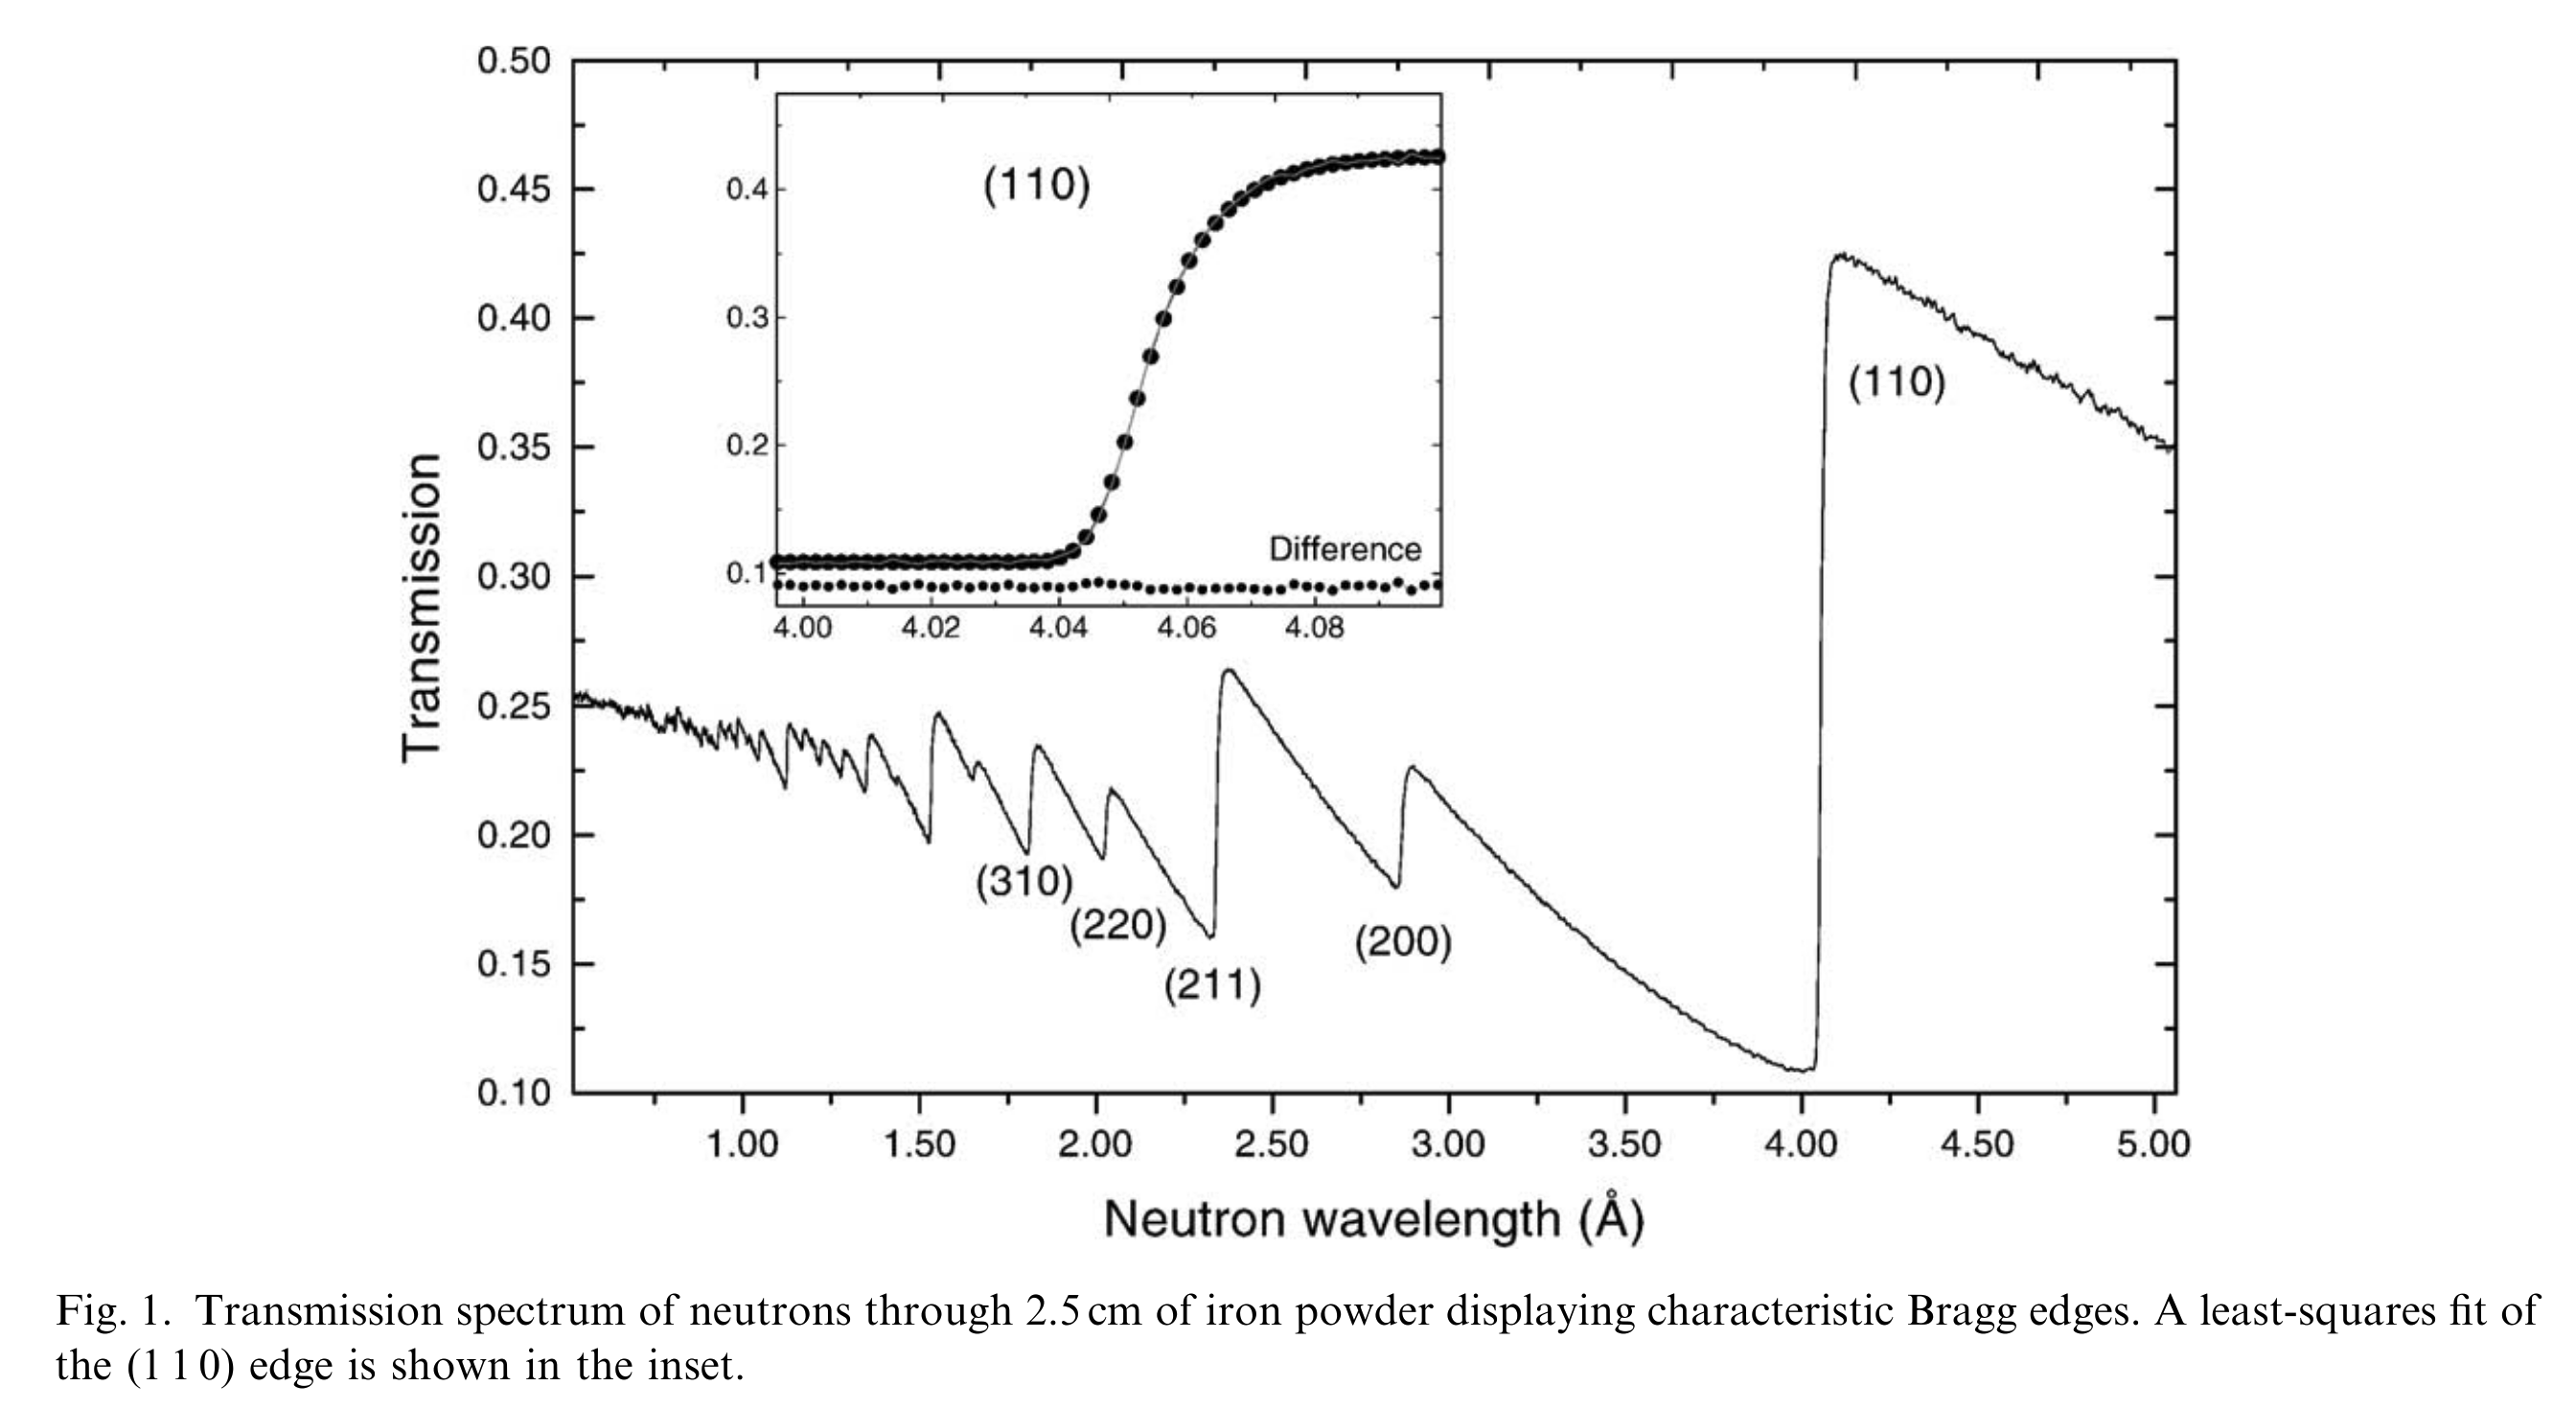

### Physics-Based Attenuation Model

The Santisteban model describes neutron transmission through a material using a physics-based attenuation model.
The attenuation factor is given by the equation:

- Atomic density ($atoms/cm^3$)

- Sample thickness ($cm$)

- Cross-section ($cm^2$)

In [2]:
def get_attenuation_factor(
    atomic_density: float,
    sample_thickness: float,
    cross_section: float,
) -> float:
    """
    Calculate the attenuation factor for a sample with given cross-section.

    Parameters
    ----------
    atomic_density : float
        The atomic density of the sample in atoms per cubic centimeter.
    sample_thickness : float
        The thickness of the sample in centimeters.
    cross_section : float
        The corresponding cross section of the sample in square centimeters.

    Returns
    -------
    float
        The attenuation factor.
    """
    return np.exp(- atomic_density * sample_thickness * cross_section)

In [3]:
# test with Iron
atomic_density_fe = 8.48e22  # Atomic density, atoms/cm^3
sample_thickness_fe = 1  # Sample thickness, cm
total_cross_section_fe = 11.62e-24  # Total cross-section at long-wavelength side, cm^2
bragg_cross_section_110_fe = 8e-24  # Bragg cross-section for (110) plane, cm^2

background_attenuation_fe = get_attenuation_factor(
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
)
bragg_attenuation_fe = get_attenuation_factor(
    atomic_density_fe,
    sample_thickness_fe,
    bragg_cross_section_110_fe,
)

print(f"Background attenuation factor: {background_attenuation_fe}")
print(f"Bragg attenuation factor: {bragg_attenuation_fe}")

Background attenuation factor: 0.3732988401816966
Bragg attenuation factor: 0.5074282283691137


### Phenomenological Peak Shape Function

The Santisteban model also introduces a phenomenological peak shape function to describe the broadening of the Bragg edge.
This broadening accounts for both instrumental effects and the properties of the sample.

$$
B(\lambda) = \frac{1}{2} \left[ \text{erfc} \left( -\frac{\lambda - \lambda_{hkl}}{\sqrt{2} \sigma} \right) - \exp \left( -\frac{\lambda - \lambda_{hkl}}{\tau} + \frac{\sigma^2}{2\tau^2} \right) \text{erfc} \left( -\frac{\lambda - \lambda_{hkl}}{\sqrt{2} \sigma} + \frac{\sigma}{\tau} \right) \right]
$$

where:

- $ \lambda $: Wavelength
- $ \lambda_{hkl} $: Bragg edge wavelength for the specific crystallographic plane
- $ \sigma $: Symmetric broadening parameter
- $ \tau $: Asymmetric broadening parameter

In [4]:
def bragg_edge_func(
    wavelength: np.ndarray,
    bragg_peak_wavelength: float,
    symmetric_broadening: float,
    asymmetric_broadening: float,
) -> np.ndarray:
    """
    Calculate the peak broadening function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    bragg_peak_wavelength : float
        The wavelength of the Bragg peak.
    symmetric_broadening : float
        The symmetric broadening of the peak.
    asymmetric_broadening : float
        The asymmetric broadening of the peak.

    Returns
    -------
    np.ndarray
        The peak broadening function.
    """
    delta_wavelength = wavelength - bragg_peak_wavelength
    broadening_ratio = symmetric_broadening / asymmetric_broadening

    part1 = special.erfc(- delta_wavelength / (np.sqrt(2)* symmetric_broadening))
    part2 = np.exp(- delta_wavelength/ asymmetric_broadening + broadening_ratio**2/2)
    part3 = special.erfc(- delta_wavelength / (np.sqrt(2)* symmetric_broadening) + broadening_ratio)

    return 0.5 * (part1 - part2 * part3)

Text(0.5, 1.0, 'Bragg Edge function for Iron')

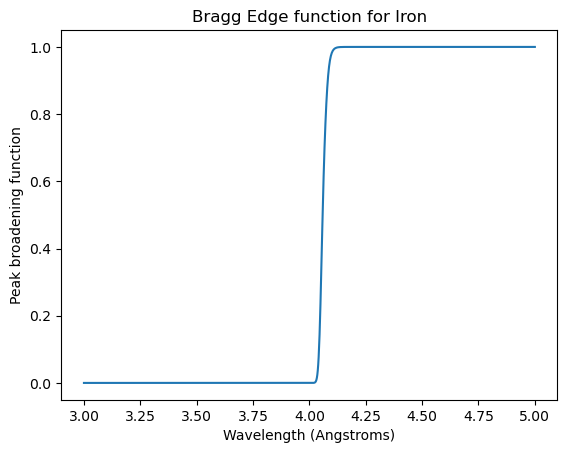

In [5]:
# test with Iron
# NOTE: we are using small broadening values to show a sharp transition
wavelength = np.linspace(3.0, 5.0, 1000)  # Wavelength values, Angstroms
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms
symmetric_broadening_fe = 1e-2  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 1e-2  # Asymmetric broadening, Angstroms

peak_broadening_fe = bragg_edge_func(
    wavelength,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

plt.plot(wavelength, peak_broadening_fe)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Peak broadening function")
plt.title("Bragg Edge function for Iron")

#### Effect of Symmetric and Asymmetric Broadening

- Symmetric Broadening:
Vary the value of  to show its effect on the peak shape.
Overlay multiple plots to demonstrate how increasing or decreasing symmetric broadening affects the width and sharpness of the Bragg edge.

- Asymmetric Broadening:
Similarly, vary the value of  to show its effect on the asymmetry of the peak.
Overlay plots to illustrate how a smaller or larger asymmetric parameter changes the tail of the Bragg edge.

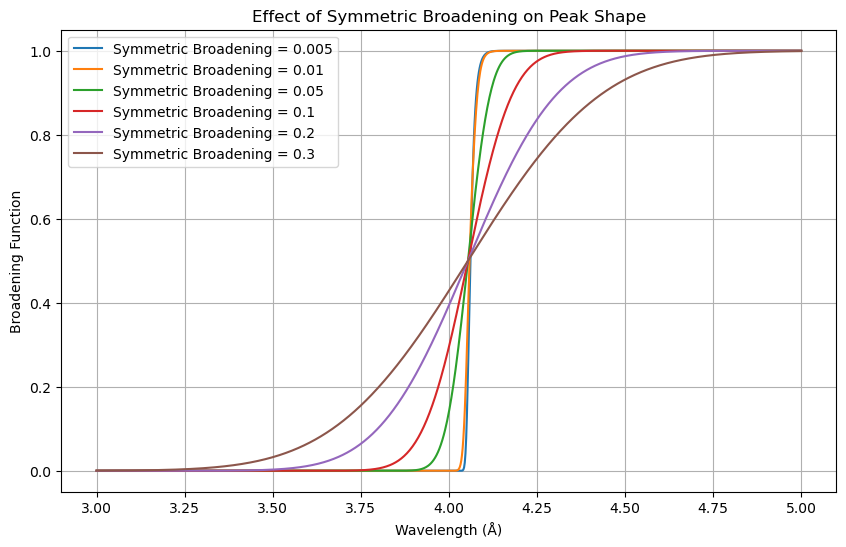

In [6]:
# Demonstrating the effect of symmetric broadening
plt.figure(figsize=(10, 6))
for sigma in [5e-3, 0.01, 0.05, 0.1, 0.2, 0.3]:
    peak_broadening = bragg_edge_func(wavelength, bragg_peak_wavelength_fe, sigma, asymmetric_broadening_fe)
    plt.plot(wavelength, peak_broadening, label=f'Symmetric Broadening = {sigma}')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Broadening Function')
plt.title('Effect of Symmetric Broadening on Peak Shape')
plt.legend()
plt.grid(True)
plt.show()

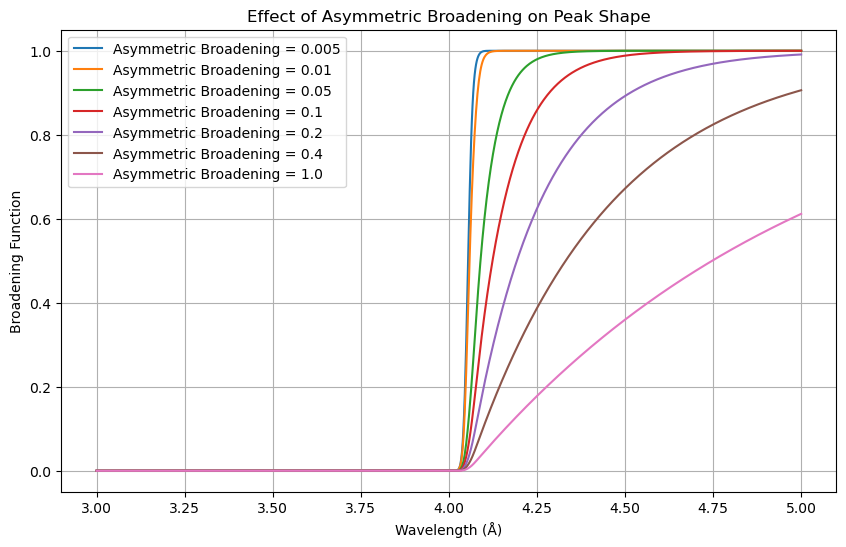

In [7]:
# Demonstrating the effect of asymmetric broadening
plt.figure(figsize=(10, 6))
for tau in [5e-3, 0.01, 0.05, 0.1, 0.2, 0.4, 1.0]:
    peak_broadening = bragg_edge_func(wavelength, bragg_peak_wavelength_fe, symmetric_broadening_fe, tau)
    plt.plot(wavelength, peak_broadening, label=f'Asymmetric Broadening = {tau}')

plt.xlabel('Wavelength (Å)')
plt.ylabel('Broadening Function')
plt.title('Effect of Asymmetric Broadening on Peak Shape')
plt.legend()
plt.grid(True)
plt.show()

Combining the peak shape function with the attenuation factor gives us the theoretical Bragg edge profile near the transition region.

In [8]:
def simulate_bragg_edge(
    wavelengths: np.ndarray,
    atomic_density: float,
    sample_thickness: float,
    total_cross_section: float,
    bragg_cross_section: float,
    bragg_wavelength: float,
    symmetric_broadening_param: float,
    asymmetric_broadening_param: float,
) -> np.ndarray:
    """
    Simulate the Bragg edge profile.

    Parameters
    ----------
    wavelengths : np.ndarray
        The wavelength values to calculate the Bragg edge profile.
    atomic_density : float
        The atomic density of the sample in atoms per cubic centimeter.
    sample_thickness : float
        The thickness of the sample in centimeters.
    total_cross_section : float
        The total cross-section at long-wavelength side, in square centimeters.
    bragg_cross_section : float
        The Bragg cross-section for HKL plane, in square centimeters.
    bragg_wavelength : float
        The wavelength of the Bragg peak.
    symmetric_broadening_param : float
        The symmetric broadening parameter.
    asymmetric_broadening_param : float
        The asymmetric broadening parameter.

    Returns
    -------
    np.ndarray
        The simulated Bragg edge profile.
    """
    background_attenuation = get_attenuation_factor(
        atomic_density,
        sample_thickness,
        total_cross_section,
    )
    bragg_attenuation = get_attenuation_factor(
        atomic_density,
        sample_thickness,
        bragg_cross_section,
    )

    peak_broadening = bragg_edge_func(
        wavelengths,
        bragg_wavelength,
        symmetric_broadening_param,
        asymmetric_broadening_param,
    )

    return background_attenuation * ( bragg_attenuation + (1 - bragg_attenuation)* peak_broadening)

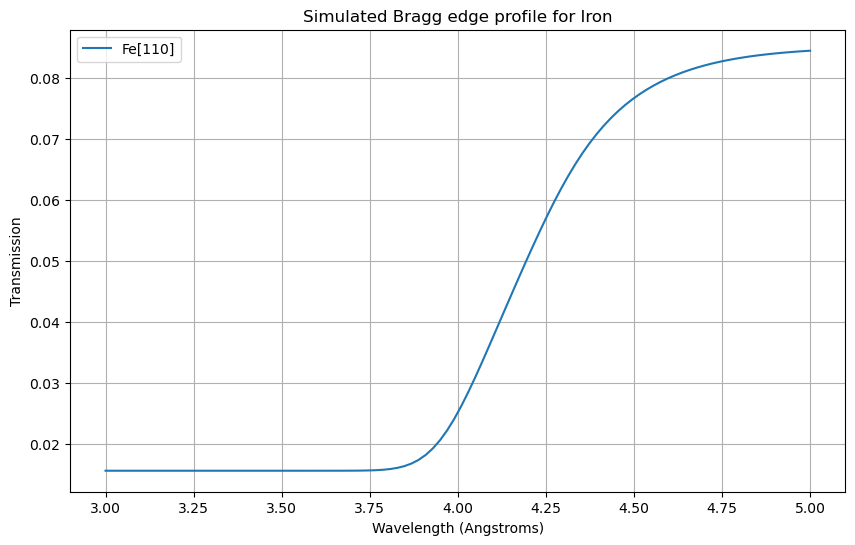

In [9]:
# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
atomic_density_fe = 8.48e22  # Atomic density, atoms/cm^3
sample_thickness_fe = 2.5  # Sample thickness, cm
total_cross_section_fe = 11.62e-24  # Total cross-section at long-wavelength side, cm^2
bragg_cross_section_110_fe = 8e-24  # Bragg cross-section for (110) plane, cm^2
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms
symmetric_broadening_fe = 0.1  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 0.2  # Asymmetric broadening, Angstroms

bragg_edge_fe = simulate_bragg_edge(
    wavelengths_fe,
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
    bragg_cross_section_110_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_fe, bragg_edge_fe, label="Fe[110]")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Simulated Bragg edge profile for Iron")
plt.legend()
plt.grid(True)
plt.show()

Since the model is focusing on fitting the Bragg edge, the low $\lambda$ and high $\lambda$ regions are not modeled explicitly, therefore resulting in the flat profile near both ends.
This becomes an issue during fitting with real data as real experiment data will have **decay** at both ends.
For manual fitting data, this is not a huge issue as scientist can manually select the fitting region, i.e. $\lambda$ range, to avoid the flat region.
However, automated fitting software like `iBeatles` needs to be able to handle this issue without huamn intervention, therefore we need to use an extended model where the region selection does not require human intervention.

## The Extended Kropff model

The extended Kropff model is a modification of the Santisteban model that includes a phenomenological attenuation model to account for the decay at the low and high $\lambda$ regions.

The extended Kropff model for the Bragg edge transmission profile is given by:

$$
Tr(\lambda) = \exp\left[-(a_0 + b_0 \lambda)\right] \left( \exp\left[-(a_{hkl} + b_{hkl} \lambda)\right] + \left[ 1 - \exp\left[-(a_{hkl} + b_{hkl} \lambda)\right] \right] B(\lambda, \sigma, \tau, \lambda) \right)
$$

where:

- $ a_0 $, $ b_0 $: Parameters for background attenuation.
- $ a_{hkl} $, $ b_{hkl} $: Parameters for the attenuation due to Bragg scattering.
- $ B(\lambda, \sigma, \tau, \lambda) $: Broadening function, which accounts for both symmetric ($ \sigma $) and asymmetric ($ \tau $) broadening effects. This is the same function as in the Santisteban model.

In this model, the high $\lambda$ decay profile is model with

$$ Tr^H(\lambda) = \exp\left[-(a_0 + b_0 \lambda)\right] $$

and the low $\lambda$ decay profile is model with

$$
Tr^L(\lambda) = \exp\left[-(a_0 + b_0 \lambda)\right] \cdot \exp\left[-(a_{hkl} + b_{hkl} \lambda)\right]
              = Tr^H(\lambda) \cdot \exp\left[-(a_{hkl} + b_{hkl} \lambda)\right]
$$

In other words, we can rewrite the extended Kropff model as


$$
Tr(\lambda) = Tr^H(\lambda)
  \left(
      \dfrac{Tr^L(\lambda)}{Tr^H(\lambda)}
    + \left[
        1 - \dfrac{Tr^L(\lambda)}{Tr^H(\lambda)}
      \right]
    \cdot B(\lambda, \sigma, \tau, \lambda)
  \right)
$$

which gives us

$$
Tr(\lambda) = Tr^L(\lambda) + (Tr^H(\lambda) - Tr^L(\lambda)) \cdot B(\lambda, \sigma, \tau, \lambda)
$$

In [10]:
def kropff_high_lambda_tranmission(
    wavelength: np.ndarray,
    a0: float,
    b0: float,
) -> np.ndarray:
    """
    Calculate the high-wavelength side transmission function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.

    Returns
    -------
    np.ndarray
        The high-wavelength side transmission function.
    """
    return np.exp(- (a0 + b0 * wavelength))

In [11]:
def kropff_low_lambda_transmission(
    wavelength: np.ndarray,
    a0: float,
    b0: float,
    a_hkl: float,
    b_hkl: float,
) -> np.ndarray:
    """
    Calculate the low-wavelength side transmission function.

    Parameters
    ----------
    wavelength : np.ndarray
        The wavelength values to calculate the function.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.
    a_hkl : float
        The a_HKL parameter.
    b_hkl : float
        The b_HKL parameter.

    Returns
    -------
    np.ndarray
        The low-wavelength side transmission function.
    """
    return np.exp(- (a0 + b0 * wavelength) - (a_hkl + b_hkl * wavelength))

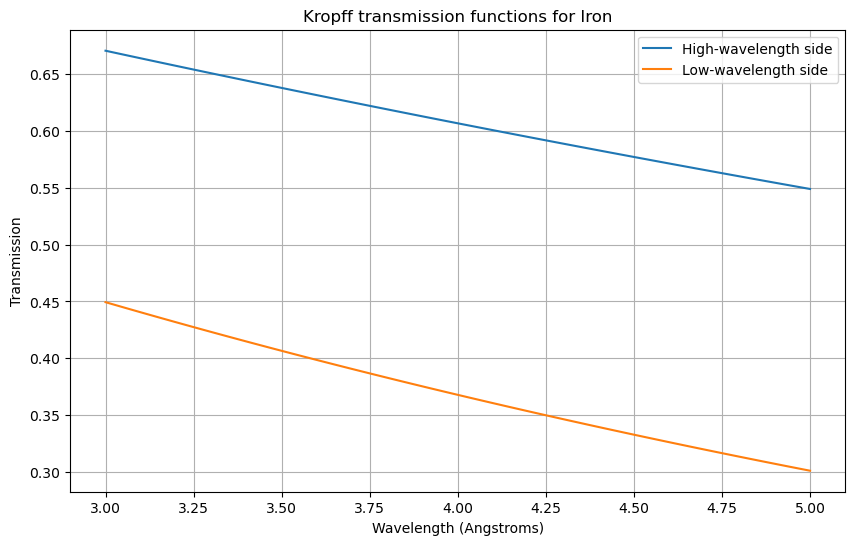

In [12]:
# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
a0_fe = 0.1  # a0 parameter
b0_fe = 0.1  # b0 parameter
a_hkl_fe = 0.1  # a_HKL parameter
b_hkl_fe = 0.1  # b_HKL parameter

high_lambda_transmission_fe = kropff_high_lambda_tranmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
)
low_lambda_transmission_fe = kropff_low_lambda_transmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
    a_hkl_fe,
    b_hkl_fe,
)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths_fe, high_lambda_transmission_fe, label="High-wavelength side")
plt.plot(wavelengths_fe, low_lambda_transmission_fe, label="Low-wavelength side")
plt.legend()
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Kropff transmission functions for Iron")
plt.grid(True)
plt.show()

In [13]:
def simulate_transmission_profile(
    wavelengths: np.ndarray,
    a0: float,
    b0: float,
    a_hkl: float,
    b_hkl: float,
    bragg_wavelength: float,
    symmetric_broadening_param: float,
    asymmetric_broadening_param: float,
) -> np.ndarray:
    """
    Simulate the transmission profile with Bragg edge.

    Parameters
    ----------
    wavelengths : np.ndarray
        The wavelength values to calculate the transmission profile.
    a0 : float
        The a0 parameter.
    b0 : float
        The b0 parameter.
    a_hkl : float
        The a_HKL parameter.
    b_hkl : float
        The b_HKL parameter.
    bragg_wavelength : float
        The wavelength of the Bragg peak.
    symmetric_broadening_param : float
        The symmetric broadening parameter.
    asymmetric_broadening_param : float
        The asymmetric broadening parameter.

    Returns
    -------
    np.ndarray
        The simulated transmission profile.
    """
    high_lambda_transmission = kropff_high_lambda_tranmission(
        wavelengths,
        a0,
        b0,
    )

    low_lambda_transmission = kropff_low_lambda_transmission(
        wavelengths,
        a0,
        b0,
        a_hkl,
        b_hkl,
    )

    peak_broadening = bragg_edge_func(
        wavelengths,
        bragg_wavelength,
        symmetric_broadening_param,
        asymmetric_broadening_param,
    )

    transmission_spectrum = low_lambda_transmission + (high_lambda_transmission - low_lambda_transmission) * peak_broadening

    return transmission_spectrum

In [14]:
# test with Iron
wavelengths_fe = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms

a0_fe = 0.1  # a0 parameter
b0_fe = 0.1  # b0 parameter
a_hkl_fe = 0.1  # a_HKL parameter
b_hkl_fe = 0.1  # b_HKL parameter

atomic_density_fe = 8.48e22  # Atomic density, atoms/cm^3
sample_thickness_fe = 2.5  # Sample thickness, cm
total_cross_section_fe = 11.62e-24  # Total cross-section at long-wavelength side, cm^2
bragg_cross_section_110_fe = 8e-24  # Bragg cross-section for (110) plane, cm^2
bragg_peak_wavelength_fe = 4.054  # Wavelength of the Bragg edge, Angstroms

symmetric_broadening_fe = 0.01  # Symmetric broadening, Angstroms
asymmetric_broadening_fe = 0.02  # Asymmetric broadening, Angstroms

low_lambda_transmission_fe = kropff_low_lambda_transmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
    a_hkl_fe,
    b_hkl_fe,
)

high_lambda_transmission_fe = kropff_high_lambda_tranmission(
    wavelengths_fe,
    a0_fe,
    b0_fe,
)

bragg_edge_profile_tranmission = simulate_transmission_profile(
    wavelengths_fe,
    a0_fe,
    b0_fe,
    a_hkl_fe,
    b_hkl_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

bragg_edge_fe = simulate_bragg_edge(
    wavelengths_fe,
    atomic_density_fe,
    sample_thickness_fe,
    total_cross_section_fe,
    bragg_cross_section_110_fe,
    bragg_peak_wavelength_fe,
    symmetric_broadening_fe,
    asymmetric_broadening_fe,
)

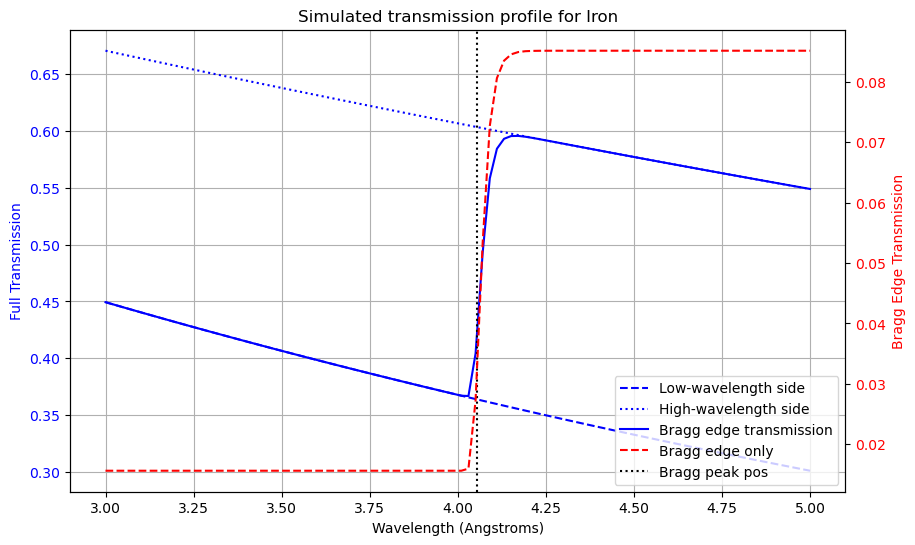

In [15]:
plt.figure(figsize=(10, 6))

# Create the first axis
ax1 = plt.gca()
line_low_lambda_transmission = ax1.plot(wavelengths_fe, low_lambda_transmission_fe, "b--", label="Low-wavelength side")
line_high_lambda_transmission = ax1.plot(wavelengths_fe, high_lambda_transmission_fe, "b:", label="High-wavelength side")
line_bragg_transmission = ax1.plot(wavelengths_fe, bragg_edge_profile_tranmission, "b-", label="Bragg edge transmission")
ax1.set_xlabel("Wavelength (Angstroms)")
ax1.set_ylabel("Full Transmission", color="blue")
ax1.set_title("Simulated transmission profile for Iron")
# set y ticks to blue
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.grid(True)

# Add vertical line for Bragg peak
bragg_pos = ax1.axvline(x=bragg_peak_wavelength_fe, color='k', linestyle=':', label="Bragg peak pos")

# Create the second axis
ax2 = ax1.twinx()
line_bragg_edge = ax2.plot(wavelengths_fe, bragg_edge_fe, "--", label="Bragg edge only", color="red")
ax2.set_ylabel("Bragg Edge Transmission", color="red")
# set y ticks to red
for tl in ax2.get_yticklabels():
    tl.set_color('r')

# combine legends
lines = line_low_lambda_transmission
lines.extend(line_high_lambda_transmission)
lines.extend(line_bragg_transmission)
lines.extend(line_bragg_edge)
lines.extend([bragg_pos])
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=4)

plt.show()

## Fitting using lmfit

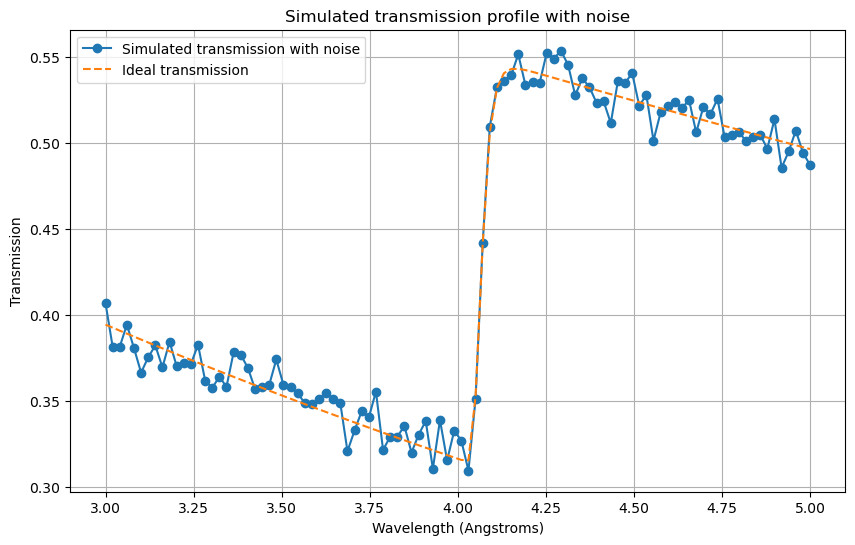

In [16]:
# reference parameters
a0 = 0.15  # a0 parameter
b0 = 0.11  # b0 parameter
a_hkl = 0.12  # a_HKL parameter
b_hkl = 0.11  # b_HKL parameter
symmetric_broadening = 0.01  # Symmetric broadening, Angstroms
asymmetric_broadening = 0.02  # Asymmetric broadening, Angstroms
bragg_peak_wavelength = 4.054  # Wavelength of the Bragg edge, Angstroms

wavelengths = np.linspace(3.0, 5.0, 100)  # Wavelength values, Angstroms
transmission_ideal = simulate_transmission_profile(
    wavelengths,
    a0,
    b0,
    a_hkl,
    b_hkl,
    bragg_peak_wavelength,
    symmetric_broadening,
    asymmetric_broadening,
)
# add noise
noise = np.random.normal(0, 0.01, len(wavelengths))
transmission = transmission_ideal + noise

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission, label="Simulated transmission with noise", marker="o")
plt.plot(wavelengths, transmission_ideal, label="Ideal transmission", linestyle="--")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Simulated transmission profile with noise")
plt.legend()
plt.grid(True)
plt.show()

### Fitting the Bragg Edge with a single-step

In [17]:
# Define the model using lmfit
model = Model(simulate_transmission_profile)

# Set initial parameters and bounds
params = model.make_params(
    a0=0.1, b0=0.1, a_hkl=0.1, b_hkl=0.1, 
    bragg_wavelength=4.0, symmetric_broadening_param=0.01, asymmetric_broadening_param=0.01
)

# Set bounds to avoid the shape function blow-up
params['a0'].min = 0
params['b0'].min = 0
params['a_hkl'].min = 0
params['b_hkl'].min = 0
params['bragg_wavelength'].min = 3.5
params['bragg_wavelength'].max = 4.5
params['symmetric_broadening_param'].min = 5e-3
params['symmetric_broadening_param'].max = 0.1
params['asymmetric_broadening_param'].min = 5e-3
params['asymmetric_broadening_param'].max = 0.1

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 175
    # data points      = 100
    # variables        = 7
    chi-square         = 1.2379e-27
    reduced chi-square = 1.3311e-29
    Akaike info crit   = -6642.15377
    Bayesian info crit = -6623.91757
    R-squared          = 1.00000000
[[Variables]]
    a0:                           0.15000000 +/- 2.0239e-14 (0.00%) (init = 0.1)
    b0:                           0.11000000 +/- 4.4200e-15 (0.00%) (init = 0.1)
    a_hkl:                        0.12000000 +/- 2.6344e-14 (0.00%) (init = 0.1)
    b_hkl:                        0.11000000 +/- 6.5431e-15 (0.00%) (init = 0.1)
    bragg_wavelength:             4.05400000 +/- 3.3826e-15 (0.00%) (init = 4)
    symmetric_broadening_param:   0.01000000 +/- 2.1581e-15 (0.00%) (init = 0.01)
    asymmetric_broadening_param:  0.02000000 +/- 3.0284e-15 (0.00%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0

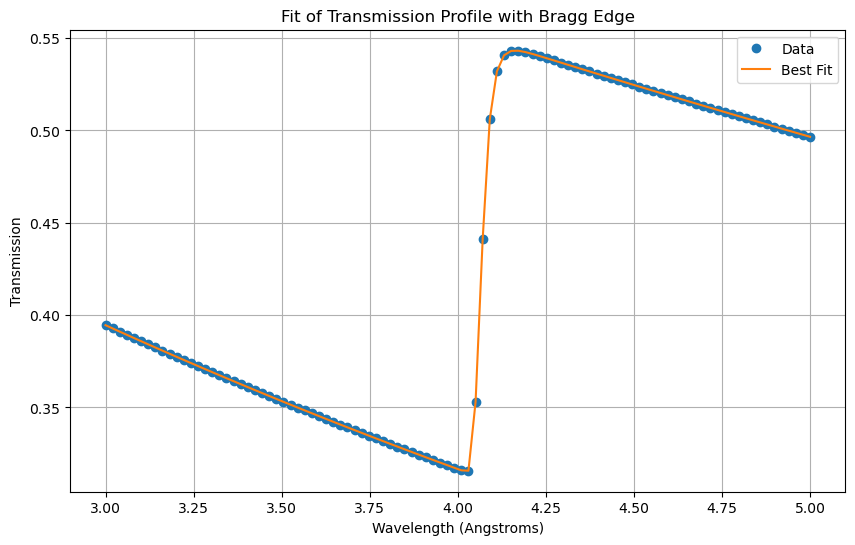

In [18]:
# For ideal data (zero noise)
fit_result_single_step = model.fit(transmission_ideal, params, wavelengths=wavelengths)

# Print the fit report
print(fit_result_single_step.fit_report())

# Plot the fitting result
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission_ideal, 'o', label='Data')
plt.plot(wavelengths, fit_result_single_step.best_fit, '-', label='Best Fit')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Fit of Transmission Profile with Bragg Edge")
plt.legend()
plt.grid(True)
plt.show()

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 100
    # variables        = 7
    chi-square         = 0.00778449
    reduced chi-square = 8.3704e-05
    Akaike info crit   = -932.079242
    Bayesian info crit = -913.843050
    R-squared          = 0.98923957
[[Variables]]
    a0:                           0.10254346 +/- 0.05071715 (49.46%) (init = 0.1)
    b0:                           0.12015628 +/- 0.01107890 (9.22%) (init = 0.1)
    a_hkl:                        0.26720437 +/- 0.06549908 (24.51%) (init = 0.1)
    b_hkl:                        0.06987890 +/- 0.01622986 (23.23%) (init = 0.1)
    bragg_wavelength:             4.05204449 +/- 0.00433348 (0.11%) (init = 4)
    symmetric_broadening_param:   0.00738927 +/- 0.00323007 (43.71%) (init = 0.01)
    asymmetric_broadening_param:  0.02324334 +/- 0.00495975 (21.34%) (init = 0.01)
[[Correlations]] (unreported correlations ar

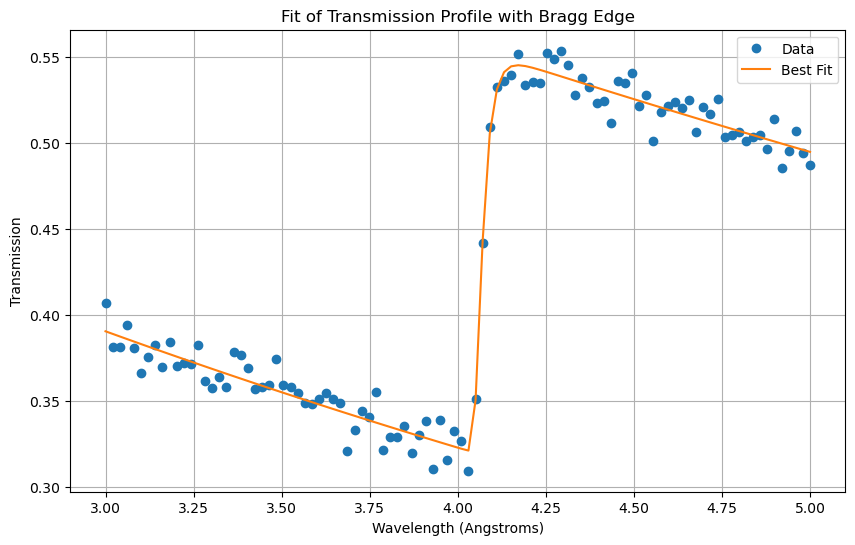

In [19]:
# with noise
# Fit the model to the data
fit_result_single_step = model.fit(transmission, params, wavelengths=wavelengths)

# Print the fit report
print(fit_result_single_step.fit_report())

# Plot the fitting result
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission, 'o', label='Data')
plt.plot(wavelengths, fit_result_single_step.best_fit, '-', label='Best Fit')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Fit of Transmission Profile with Bragg Edge")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Compare the fitting results with the reference parameters
# Var, Fitted_value, Reference_value
fit_results = [
    ('a0', fit_result_single_step.params['a0'].value, a0),
    ('b0', fit_result_single_step.params['b0'].value, b0),
    ('a_hkl', fit_result_single_step.params['a_hkl'].value, a_hkl),
    ('b_hkl', fit_result_single_step.params['b_hkl'].value, b_hkl),
    ('bragg_wavelength', fit_result_single_step.params['bragg_wavelength'].value, bragg_peak_wavelength),
    ('symmetric_broadening_param', fit_result_single_step.params['symmetric_broadening_param'].value, symmetric_broadening),
    ('asymmetric_broadening_param', fit_result_single_step.params['asymmetric_broadening_param'].value, asymmetric_broadening),
]

print("Parameter, Fitted Value, Reference Value")
for item in fit_results:
    print(item)

Parameter, Fitted Value, Reference Value
('a0', np.float64(0.10254346430273831), 0.15)
('b0', np.float64(0.12015627782889116), 0.11)
('a_hkl', np.float64(0.26720437006887443), 0.12)
('b_hkl', np.float64(0.06987890009249265), 0.11)
('bragg_wavelength', np.float64(4.052044493314571), 4.054)
('symmetric_broadening_param', np.float64(0.007389270680355082), 0.01)
('asymmetric_broadening_param', np.float64(0.02324334308483759), 0.02)


Single fitting step works really well with ideal data (zero noise), but not so much with data with noise.

### Fitting with multi-step

First, let's try multi step refinement.

In [21]:
# Define the model using lmfit
model = Model(simulate_transmission_profile)

In [22]:
# first, use blind fit to get initial guess
initial_guess = model.fit(
    transmission,
    wavelengths=wavelengths,
    a0=0.1,
    b0=0.1,
    a_hkl=0.1,
    b_hkl=0.1,
    bragg_wavelength=Parameter("bragg_wavelength", value=4.0, min=3.5, max=4.5, vary=True),
    symmetric_broadening_param=Parameter("symmetric_broadening_param", value=0.01, min=5e-3, max=0.1, vary=True),
    asymmetric_broadening_param=Parameter("asymmetric_broadening_param", value=0.01, min=5e-3, max=0.1, vary=True),
)

print(initial_guess.fit_report())

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 173
    # data points      = 100
    # variables        = 7
    chi-square         = 0.00778449
    reduced chi-square = 8.3704e-05
    Akaike info crit   = -932.079242
    Bayesian info crit = -913.843050
    R-squared          = 0.98923957
[[Variables]]
    a0:                           0.10253829 +/- 0.05071947 (49.46%) (init = 0.1)
    b0:                           0.12015738 +/- 0.01107921 (9.22%) (init = 0.1)
    a_hkl:                        0.26721059 +/- 0.06550060 (24.51%) (init = 0.1)
    b_hkl:                        0.06987749 +/- 0.01623020 (23.23%) (init = 0.1)
    bragg_wavelength:             4.05204314 +/- 0.00433365 (0.11%) (init = 4)
    symmetric_broadening_param:   0.00738810 +/- 0.00322856 (43.70%) (init = 0.01)
    asymmetric_broadening_param:  0.02324489 +/- 0.00495977 (21.34%) (init = 0.01)
[[Correlations]] (unreported correlations ar

In [23]:
# refinement step 1: focusing on a0 and b0, fixing all the other parameters
refinement_a0_b0 = model.fit(
    transmission,
    wavelengths=wavelengths,
    a0=Parameter("a0", value=initial_guess.params["a0"].value, vary=True),
    b0=Parameter("b0", value=initial_guess.params["b0"].value, vary=True),
    a_hkl=Parameter("a_hkl", value=initial_guess.params["a_hkl"].value, vary=False),
    b_hkl=Parameter("b_hkl", value=initial_guess.params["b_hkl"].value, vary=False),
    bragg_wavelength=Parameter("bragg_wavelength", value=initial_guess.params["bragg_wavelength"].value, vary=False),
    symmetric_broadening_param=Parameter("symmetric_broadening_param", value=initial_guess.params["symmetric_broadening_param"].value, vary=False),
    asymmetric_broadening_param=Parameter("asymmetric_broadening_param", value=initial_guess.params["asymmetric_broadening_param"].value, vary=False),
)

print(refinement_a0_b0.fit_report())

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 100
    # variables        = 2
    chi-square         = 0.00778449
    reduced chi-square = 7.9434e-05
    Akaike info crit   = -942.079242
    Bayesian info crit = -936.868901
    R-squared          = 0.98923957
[[Variables]]
    a0:                           0.10253828 +/- 0.01499843 (14.63%) (init = 0.1025383)
    b0:                           0.12015738 +/- 0.00356599 (2.97%) (init = 0.1201574)
    a_hkl:                        0.2672106 (fixed)
    b_hkl:                        0.06987749 (fixed)
    bragg_wavelength:             4.052043 (fixed)
    symmetric_broadening_param:   0.007388104 (fixed)
    asymmetric_broadening_param:  0.02324489 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, b0) = -0.9909


In [24]:
# refinement step 2: focusing on a_hkl and b_hkl, fixing all the other parameters
refinement_a_hkl_b_hkl = model.fit(
    transmission,
    wavelengths=wavelengths,
    a0=Parameter("a0", value=refinement_a0_b0.params["a0"].value, vary=False),
    b0=Parameter("b0", value=refinement_a0_b0.params["b0"].value, vary=False),
    a_hkl=Parameter("a_hkl", value=initial_guess.params["a_hkl"].value, vary=True),
    b_hkl=Parameter("b_hkl", value=initial_guess.params["b_hkl"].value, vary=True),
    bragg_wavelength=Parameter("bragg_wavelength", value=initial_guess.params["bragg_wavelength"].value, vary=False),
    symmetric_broadening_param=Parameter("symmetric_broadening_param", value=initial_guess.params["symmetric_broadening_param"].value, vary=False),
    asymmetric_broadening_param=Parameter("asymmetric_broadening_param", value=initial_guess.params["asymmetric_broadening_param"].value, vary=False),
)

print(refinement_a_hkl_b_hkl.fit_report())

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 100
    # variables        = 2
    chi-square         = 0.00778449
    reduced chi-square = 7.9434e-05
    Akaike info crit   = -942.079242
    Bayesian info crit = -936.868901
    R-squared          = 0.98923957
[[Variables]]
    a0:                           0.1025383 (fixed)
    b0:                           0.1201574 (fixed)
    a_hkl:                        0.26721058 +/- 0.03923211 (14.68%) (init = 0.2672106)
    b_hkl:                        0.06987749 +/- 0.01119994 (16.03%) (init = 0.06987749)
    bragg_wavelength:             4.052043 (fixed)
    symmetric_broadening_param:   0.007388104 (fixed)
    asymmetric_broadening_param:  0.02324489 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_hkl, b_hkl) = -0.9961


In [25]:
# refinement step 3: focusing on bragg_wavelength, symmetric_broadening_param, and asymmetric_broadening_param, fixing all the other parameters
fit_results_with_multi_step_refinement = model.fit(
    transmission,
    wavelengths=wavelengths,
    a0=Parameter("a0", value=refinement_a0_b0.params["a0"].value, vary=False),
    b0=Parameter("b0", value=refinement_a0_b0.params["b0"].value, vary=False),
    a_hkl=Parameter("a_hkl", value=refinement_a_hkl_b_hkl.params["a_hkl"].value, vary=False),
    b_hkl=Parameter("b_hkl", value=refinement_a_hkl_b_hkl.params["b_hkl"].value, vary=False),
    bragg_wavelength=Parameter("bragg_wavelength", value=initial_guess.params["bragg_wavelength"].value, min=3.5, max=4.5, vary=True),
    symmetric_broadening_param=Parameter("symmetric_broadening_param", value=initial_guess.params["symmetric_broadening_param"].value, min=5e-3, max=0.1, vary=True),
    asymmetric_broadening_param=Parameter("asymmetric_broadening_param", value=initial_guess.params["asymmetric_broadening_param"].value, min=5e-3, max=0.1, vary=True),
)

print(fit_results_with_multi_step_refinement.fit_report())


[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 100
    # variables        = 3
    chi-square         = 0.00778449
    reduced chi-square = 8.0252e-05
    Akaike info crit   = -940.079242
    Bayesian info crit = -932.263731
    R-squared          = 0.98923957
[[Variables]]
    a0:                           0.1025383 (fixed)
    b0:                           0.1201574 (fixed)
    a_hkl:                        0.2672106 (fixed)
    b_hkl:                        0.06987749 (fixed)
    bragg_wavelength:             4.05204401 +/- 0.00403045 (0.10%) (init = 4.052043)
    symmetric_broadening_param:   0.00738897 +/- 0.00308106 (41.70%) (init = 0.007388104)
    asymmetric_broadening_param:  0.02324399 +/- 0.00431065 (18.55%) (init = 0.02324489)
[[Correlations]] (unreported correlations are < 0.100)
    C(bragg_wavelength, asymmetric_broadening_param)           = -0.9212
    C(bragg_wave

Now, let's try the multi-step fitting method from Ramadhan's thesis

[[Model]]
    Model(kropff_high_lambda_tranmission)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 40
    # variables        = 2
    chi-square         = 0.00309529
    reduced chi-square = 8.1455e-05
    Akaike info crit   = -374.670075
    Bayesian info crit = -371.292317
    R-squared          = 0.74554725
[[Variables]]
    a0:  0.08310332 +/- 0.05420846 (65.23%) (init = 0.1)
    b0:  0.12426998 +/- 0.01178843 (9.49%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a0, b0) = -0.9987


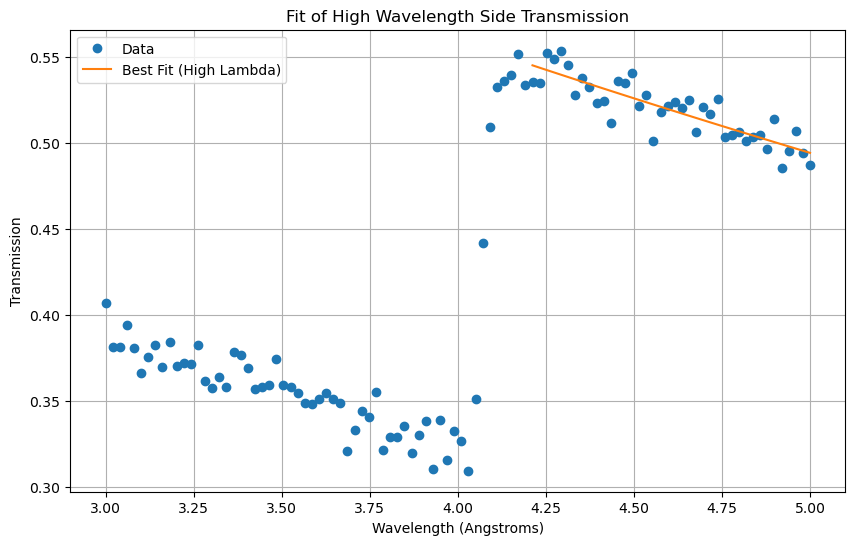

In [26]:
# Define the model using lmfit for the high lambda region
model_high_lambda = Model(kropff_high_lambda_tranmission)

# Create initial parameters for the model
params_high_lambda = model_high_lambda.make_params()

# Set initial guesses for the parameters
params_high_lambda['a0'].set(value=0.1, vary=True)  # Allow a0 to vary
params_high_lambda['b0'].set(value=0.1, vary=True)  # Allow b0 to vary

# Fit the high lambda region
results_high_lambda = model_high_lambda.fit(
    transmission[wavelengths > 4.2],
    params=params_high_lambda,
    wavelength=wavelengths[wavelengths > 4.2]
)

# Print the fit report
print(results_high_lambda.fit_report())

# Plot the fitting result
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission, 'o', label='Data')
plt.plot(wavelengths[wavelengths > 4.2], results_high_lambda.best_fit, '-', label='Best Fit (High Lambda)')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Fit of High Wavelength Side Transmission")
plt.legend()
plt.grid(True)
plt.show()


[[Model]]
    Model(kropff_low_lambda_transmission)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 38
    # variables        = 2
    chi-square         = 0.00282619
    reduced chi-square = 7.8505e-05
    Akaike info crit   = -357.243676
    Bayesian info crit = -353.968504
    R-squared          = 0.73872762
[[Variables]]
    a0:     0.08310332 (fixed)
    b0:     0.12427 (fixed)
    a_hkl:  0.32160775 +/- 0.05991967 (18.63%) (init = 0.1)
    b_hkl:  0.05506708 +/- 0.01781502 (32.35%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_hkl, b_hkl) = -0.9978


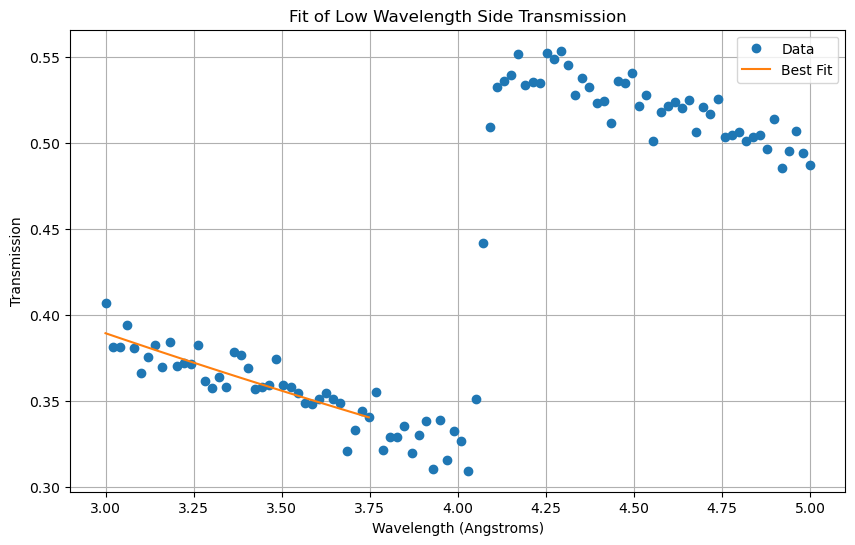

In [27]:
# assume we have the correct a0 and b0, let's find a_HKL and b_HKL using only the low wavelength side
# Define the model using lmfit
model_low_lambda = Model(kropff_low_lambda_transmission)

# Create initial parameters
params_low_lambda = model_low_lambda.make_params()

# Set parameters, fixing a0 and b0, and initializing a_hkl and b_hkl
params_low_lambda['a0'].set(value=results_high_lambda.params["a0"].value, vary=False)
params_low_lambda['b0'].set(value=results_high_lambda.params["b0"].value, vary=False)
params_low_lambda['a_hkl'].set(value=0.1, vary=True)
params_low_lambda['b_hkl'].set(value=0.1, vary=True)

# Fit the low lambda region
results_low_lambda = model_low_lambda.fit(
    transmission[wavelengths < 3.75],
    params=params_low_lambda,
    wavelength=wavelengths[wavelengths < 3.75]
)

print(results_low_lambda.fit_report())

# Plot the fitting result
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission, 'o', label='Data')
plt.plot(wavelengths[wavelengths < 3.75], results_low_lambda.best_fit, '-', label='Best Fit')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Fit of Low Wavelength Side Transmission")
plt.legend()
plt.grid(True)
plt.show()

[[Model]]
    Model(simulate_transmission_profile)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 100
    # variables        = 3
    chi-square         = 0.00790331
    reduced chi-square = 8.1477e-05
    Akaike info crit   = -938.564386
    Bayesian info crit = -930.748875
    R-squared          = 0.98907533
[[Variables]]
    a0:                           0.08310332 (fixed)
    b0:                           0.12427 (fixed)
    a_hkl:                        0.3216077 (fixed)
    b_hkl:                        0.05506708 (fixed)
    bragg_wavelength:             4.05176086 +/- 0.00384974 (0.10%) (init = 4)
    symmetric_broadening_param:   0.00687512 +/- 0.00304553 (44.30%) (init = 0.01)
    asymmetric_broadening_param:  0.02432885 +/- 0.00422628 (17.37%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(bragg_wavelength, asymmetric_broadening_param)           = -0.9115
    C(bragg_wavelength, symmetric_br

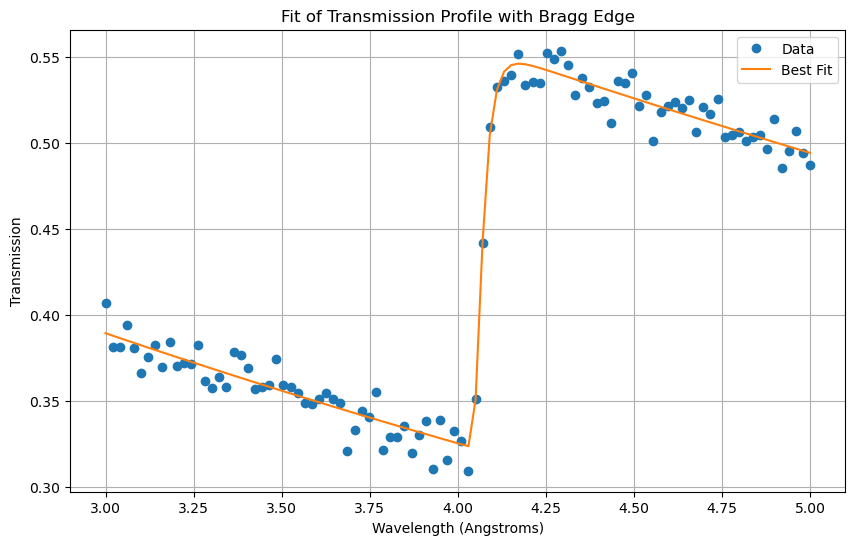

In [28]:
# Now we have a0, b0, a_hkl and b_hkl, let's fix them and fit the whole data for the Bragg peak position and broadening parameters
# Define the model using lmfit
model_full = Model(simulate_transmission_profile)

# Create initial parameters
params_full = model_full.make_params()
params_full['a0'].set(value=results_high_lambda.params["a0"].value, vary=False)
params_full['b0'].set(value=results_high_lambda.params["b0"].value, vary=False)
params_full['a_hkl'].set(value=results_low_lambda.params["a_hkl"].value, vary=False)
params_full['b_hkl'].set(value=results_low_lambda.params["b_hkl"].value, vary=False)
params_full['bragg_wavelength'].set(value=4.0, min=3.5, max=4.5, vary=True)
params_full['symmetric_broadening_param'].set(value=0.01, min=5e-3, max=0.1, vary=True)
params_full['asymmetric_broadening_param'].set(value=0.01, min=5e-3, max=0.1, vary=True)

# Fit the full data
fit_results_multi_step_fit = model_full.fit(
    transmission,
    params=params_full,
    wavelengths=wavelengths
)

print(fit_results_multi_step_fit.fit_report())

# Plot the fitting result
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, transmission, 'o', label='Data')
plt.plot(wavelengths, fit_results_multi_step_fit.best_fit, '-', label='Best Fit')
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Transmission")
plt.title("Fit of Transmission Profile with Bragg Edge")
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Define the columns for the comparison table
columns = [
    'Parameter', 
    'Reference Value', 
    'Single Step Fit', 'Single Step Error',
    'Post Refinement Fit', 'Post Refinement Error', 
    'Multi Step Fit', 'Multi Step Error'
]

# Define the fitting results including error calculations
fit_results = [
    ('a0', a0,
     fit_result_single_step.params['a0'].value, abs(fit_result_single_step.params['a0'].value - a0),
     refinement_a0_b0.params['a0'].value, abs(refinement_a0_b0.params['a0'].value - a0),
     results_high_lambda.params['a0'].value, abs(results_high_lambda.params['a0'].value - a0)),
    
    ('b0', b0,
     fit_result_single_step.params['b0'].value, abs(fit_result_single_step.params['b0'].value - b0),
     refinement_a0_b0.params['b0'].value, abs(refinement_a0_b0.params['b0'].value - b0),
     results_high_lambda.params['b0'].value, abs(results_high_lambda.params['b0'].value - b0)),
    
    ('a_hkl', a_hkl,
     fit_result_single_step.params['a_hkl'].value, abs(fit_result_single_step.params['a_hkl'].value - a_hkl),
     refinement_a_hkl_b_hkl.params['a_hkl'].value, abs(refinement_a_hkl_b_hkl.params['a_hkl'].value - a_hkl),
     results_low_lambda.params['a_hkl'].value, abs(results_low_lambda.params['a_hkl'].value - a_hkl)),
    
    ('b_hkl', b_hkl,
     fit_result_single_step.params['b_hkl'].value, abs(fit_result_single_step.params['b_hkl'].value - b_hkl),
     refinement_a_hkl_b_hkl.params['b_hkl'].value, abs(refinement_a_hkl_b_hkl.params['b_hkl'].value - b_hkl),
     results_low_lambda.params['b_hkl'].value, abs(results_low_lambda.params['b_hkl'].value - b_hkl)),
    
    ('bragg_wavelength', bragg_peak_wavelength,
     fit_result_single_step.params['bragg_wavelength'].value, abs(fit_result_single_step.params['bragg_wavelength'].value - bragg_peak_wavelength),
     fit_results_with_multi_step_refinement.params['bragg_wavelength'].value, abs(fit_results_with_multi_step_refinement.params['bragg_wavelength'].value - bragg_peak_wavelength),
     fit_results_multi_step_fit.params['bragg_wavelength'].value, abs(fit_results_multi_step_fit.params['bragg_wavelength'].value - bragg_peak_wavelength)),
    
    ('symmetric_broadening_param', symmetric_broadening,
     fit_result_single_step.params['symmetric_broadening_param'].value, abs(fit_result_single_step.params['symmetric_broadening_param'].value - symmetric_broadening),
     fit_results_with_multi_step_refinement.params['symmetric_broadening_param'].value, abs(fit_results_with_multi_step_refinement.params['symmetric_broadening_param'].value - symmetric_broadening),
     fit_results_multi_step_fit.params['symmetric_broadening_param'].value, abs(fit_results_multi_step_fit.params['symmetric_broadening_param'].value - symmetric_broadening)),
    
    ('asymmetric_broadening_param', asymmetric_broadening,
     fit_result_single_step.params['asymmetric_broadening_param'].value, abs(fit_result_single_step.params['asymmetric_broadening_param'].value - asymmetric_broadening),
     fit_results_with_multi_step_refinement.params['asymmetric_broadening_param'].value, abs(fit_results_with_multi_step_refinement.params['asymmetric_broadening_param'].value - asymmetric_broadening),
     fit_results_multi_step_fit.params['asymmetric_broadening_param'].value, abs(fit_results_multi_step_fit.params['asymmetric_broadening_param'].value - asymmetric_broadening))
]

# Create a DataFrame to hold the fitting results
df_fit_results = pd.DataFrame(fit_results, columns=columns)

df_fit_results


,Parameter,Reference Value,Single Step Fit,Single Step Error,Post Refinement Fit,Post Refinement Error,Multi Step Fit,Multi Step Error
0,a0,0.150,0.102543,0.047457,0.102538,0.047462,0.083103,0.066897
1,b0,0.110,0.120156,0.010156,0.120157,0.010157,0.124270,0.014270
2,a_hkl,0.120,0.267204,0.147204,0.267211,0.147211,0.321608,0.201608
3,b_hkl,0.110,0.069879,0.040121,0.069877,0.040123,0.055067,0.054933
4,bragg_wavelength,4.054,4.052044,0.001956,4.052044,0.001956,4.051761,0.002239
5,symmetric_broadening_param,0.010,0.007389,0.002611,0.007389,0.002611,0.006875,0.003125
6,asymmetric_broadening_param,0.020,0.023243,0.003243,0.023244,0.003244,0.024329,0.004329
